In [1]:
import random
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0,8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [104]:
train_data = CIFAR10(root='./CIFAR', train=True, transform=transforms.ToTensor(),download=True)
test_data = CIFAR10(root='./CIFAR',train=False, transform=transforms.ToTensor(),download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
X_train =train_data.data
y_train =np.array(train_data.targets)

X_test =test_data.data
y_test =np.array(test_data.targets)

In [4]:
print('Training data shape: ', X_train.shape)
print('Training labels shape:', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape:', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape: (10000,)


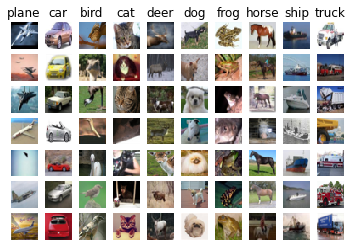

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

for y,cls in enumerate(classes):
  idxs = np.flatnonzero(y_train==y)
  idxs = np.random.choice(idxs,samples_per_class,replace=False)
  for i,idx in enumerate(idxs):
    plt_idx = i*num_classes +y+1
    plt.subplot(samples_per_class,num_classes,plt_idx)
    plt.imshow(X_train[idx].astype('uint8'))
    plt.axis('off')
    if i==0:
      plt.title(cls)

plt.show()

In [6]:
num_training = 5000
mask = list(range(num_training))

X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [136]:
X_train = np.reshape(X_train,(X_train.shape[0],-1)).astype('float')
X_test = np.reshape(X_test,(X_test.shape[0],-1)).astype('float')

print(X_train.shape,X_test.shape)

(5000, 3072) (500, 3072)


In [122]:
class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the 
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
  
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      for j in range(num_train):
        dist =np.sqrt(np.sum((self.X_train[j,:]-X[i,:])**2))
        dists[i,j] = dist
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(0,num_test):
     dist = np.sqrt(np.sum((self.X_train-X[i,:])**2,axis=1))
     dists[i] = dist
    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
   
    test_square = np.sum(np.square(X),axis=1).reshape((num_test,1))
    train_square = np.sum(np.square(self.X_train),axis=1).reshape((1,num_train))

    dists = np.sqrt(test_square+train_square-2*np.matmul(X,self.X_train.T))

    #a와 b의 유클리드 거리 = ((a-b)^2 들의 합)^1/2 = (a^2-2ab+b^2 들의 합)^1/2
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.
      closest_y = []
      closest_y = self.y_train[np.argsort(dists[i])[:k]]
     
      y_pred[i] = np.bincount(closest_y).argmax()

    return y_pred


In [137]:
classifier = KNearestNeighbor()
classifier.train(X_train,y_train)

In [138]:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


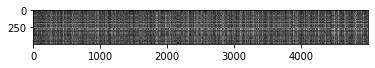

In [139]:
plt.imshow(dists,interpolation='none')
plt.show()

In [140]:
y_test_pred = classifier.predict_labels(dists,k=5)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


In [141]:
dists_one = classifier.compute_distances_one_loop(X_test)
difference = np.linalg.norm(dists-dists_one,ord='fro')
print('Difference was: %f'%difference)

if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [142]:
dists_two = classifier.compute_distances_no_loops(X_test)

difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [145]:
def time_function(f,*args):
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc-tic

two_loop_time = time_function(classifier.compute_distances_two_loops,X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop,X_test)
print('One loop version took %f seconds' % one_loop_time)

zero_loop_time = time_function(classifier.compute_distances_no_loops,X_test)
print('No loop version took %f seconds' % zero_loop_time)

Two loop version took 38.595386 seconds
One loop version took 27.019931 seconds
No loop version took 0.548923 seconds


In [170]:
num_folds = 5
k_choice = [1,3,5,8,10,12,15,20,50,100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)

k_to_accuracies = {}

for k in k_choice:
  k_to_accuracies[k] = []

  for i in range(num_folds):
    X_train_fold = np.concatenate([x for num,x in enumerate(X_train_folds) if num!=i])
    y_train_fold = np.concatenate([y for num,y in enumerate(y_train_folds) if num!=i])

    classifier.train(X_train_fold,y_train_fold)
    y_pred = classifier.predict(X_train_folds[i],k,num_loops=0)
    num_correct = (y_train_folds[i] == y_pred).sum()

    accuracy = float(num_correct) / len(y_pred)
    k_to_accuracies[k].append(accuracy)

for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

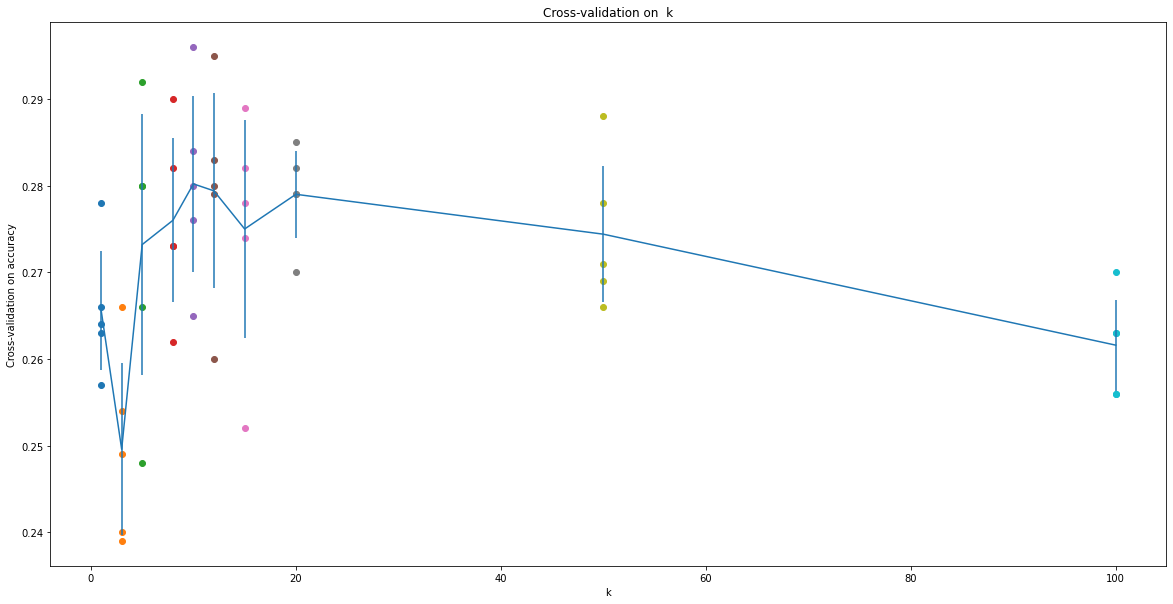

In [171]:
plt.figure(figsize=(20,10))
for k in k_choice:
  accuracies = k_to_accuracies[k]
  plt.scatter([k]*len(accuracies),accuracies)

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choice,accuracies_mean,accuracies_std)
plt.title('Cross-validation on  k')
plt.xlabel('k')
plt.ylabel('Cross-validation on accuracy')

plt.show()

In [172]:
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train,y_train)
y_test_pred = classifier.predict(X_test,k=best_k)

num_correct = (y_test_pred == y_test).sum()
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
